<a href="https://colab.research.google.com/github/maitri99/18335/blob/master/Keystone_Resume_Parser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Keystone Resume Parser
Team Members: Asma Sadia, Daniel Lichter, David Balaban, Maitri Patel

## Table of Contents:
* [Part 1. Problem Statement](#part-one)
* [Part 2. Exploratory Data Analysis](#part-two)
* [Part 3. Modeling](#part-three)
* [Part 4. Results](#part-four)
* [Part 5. Impact](#part-five)


**Loading Libraries**

In [ ]:
!apt-get install poppler-utils
!pip install pdf2image
!pip install easyocr

In [ ]:
from pdf2image import convert_from_path
import pdf2image #converts pdf
import easyocr
import numpy as np
import PIL # Python Imaging Library
from PIL import ImageDraw # drawing bounding boxes
import tensorflow as tf
from IPython.display import display,Image
from matplotlib.pyplot import imshow
import xml.dom.minidom
import pandas as pd
import mrcnn
import mrcnn.utils
import mrcnn.config
import mrcnn.model
import mrcnn.visualize
import urllib.request
import os
import xml.etree
import cv2

from pdf2image import convert_from_path
from IPython.display import display,Image
import easyocr
import numpy as np
import PIL # Python Imaging Library
from PIL import ImageDraw, Image # drawing bounding boxes
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from annotate import *
import resume_eda

reader = easyocr.Reader(['en'])

## Problem Statement <a id="part-one"></a>

Many universities and student organizations collect resume books, containing hundreds of student resumes, to send out to different companies looking to hire. Keystone Strategy's recruiting team often recieve these resume books, which they then have to manually parse to catalog simple attributes about individuals, before doing a more detailed review for fit with the organization.

Keystone would like to automate this initial step using machine learning. A machine learning-based resume parser will save Keystone recruiters from hours of work by eliminating manual processing and analysis for every resume they receive. Using different machine learning models, an accurate and faster system can be made to parse these resumes and make hiring new employees that much easier.

## Exploratory Data Analysis <a id="part-two"></a>

Our custom dataset consists of resumes from three resume books from graduate business schools such as Tuck School of Business at Dartmouth, Haas School of Business at Berekely, and Standard Graduate School of Business. In total, there are 841 resumes of MBA candidates. The Stanford university had 428 resumes, while Berekely had 212 and Dartmouth had 201 resumes. There are 5 two page resumes with 2 from the Stanford resume book and 3 from the Dartmouth resume book. There is only one column-based resume from the Stanford resume book. We anticipate that the predictions for the column-based resumes would have poor performance due to the lack of column-based resumes in our dataset.

Below are graphs showing the breakdown of the different types of resumes in our dataset.

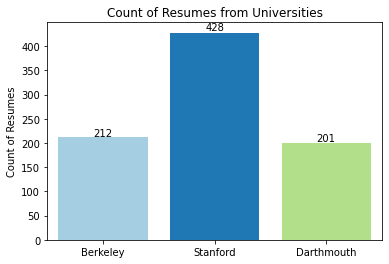

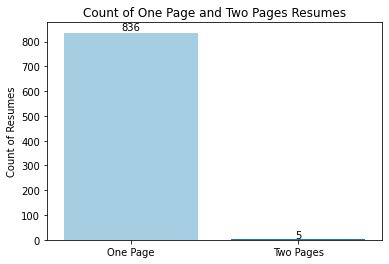

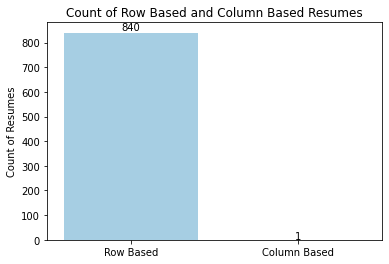

In [ ]:
uni_count = [212,428,201]
uni=['Berkeley','Stanford','Darthmouth']
ax = sns.barplot(x = uni, y = uni_count, palette = "Paired", saturation = 2.0)
labels(ax)
plt.title("Count of Resumes from Universities")
plt.show()

page_count = [836,5]
page_type=['One Page','Two Pages']
ax = sns.barplot(x = page_type, y = page_count, palette = "Paired", saturation = 2.0)
labels(ax)
plt.title("Count of One Page and Two Pages Resumes")
plt.show()

base_count= [840,1]
base =['Row Based','Column Based']
ax = sns.barplot(x = base, y = base_count, palette = "Paired", saturation = 2.0)
labels(ax)
plt.title("Count of Row Based and Column Based Resumes")
plt.show()

**Data Transformation**



The resume books were in PDF format so they needed to be converted into images to function with the maskrcnn model. The individual resumes were saved as a.jpg file. From these resumes, we want to extract attributes about individuals such as education, work experience, skills, etc.  Anything not included in any of these categories will be considered extra. Therefore, we annotated the images or create borders around these attributes, known as a bounding box, to generate the training dataset.

In [ ]:
images = convert_from_path("Haas Class of 2022 Resume Book.PDF", size=(1700,2200))

To illustrate the data that goes into the model, we will look at an example resume.

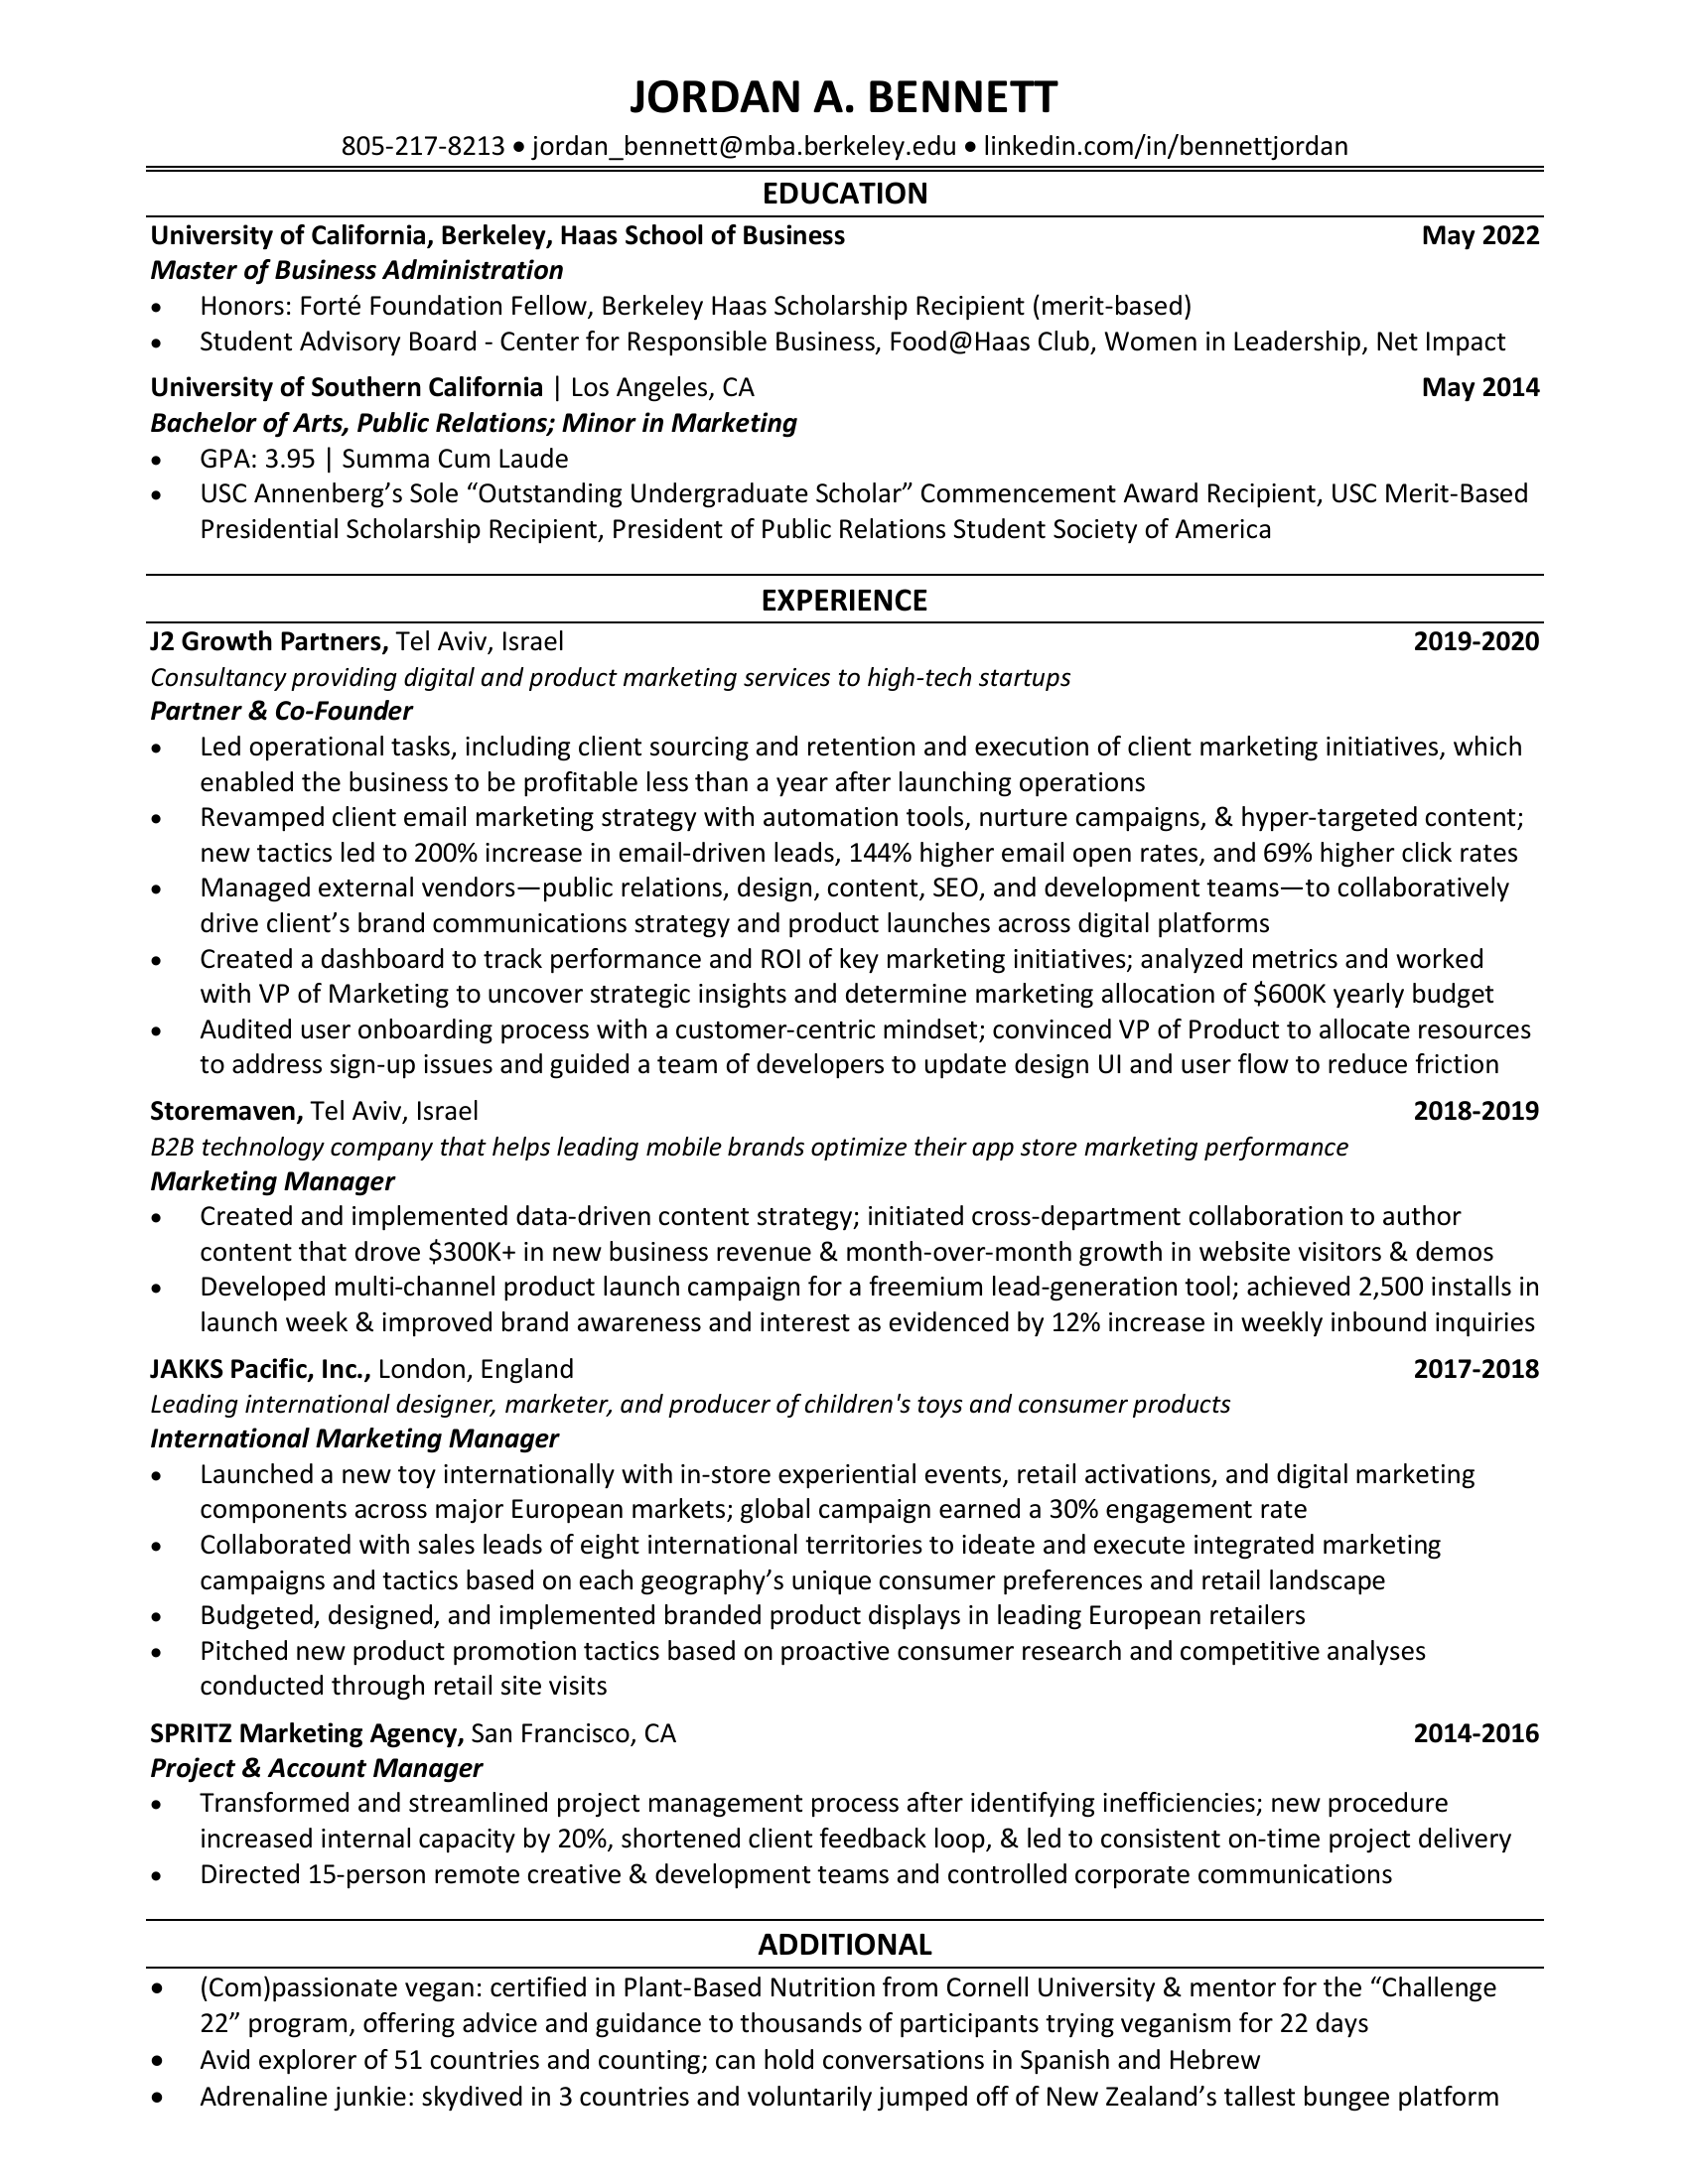

In [ ]:
display(images[21])

In order to train the model, we need to extract the text from the resume, get the coordinates of the desired headers, determine what type of resume it is, and finally create and label the bounding boxes. The code below shows the process of annotating the training resumes.

Initially this was done manually, by coming up with bounding boxes and adjusting them manually, but once we got this code running we were able to really speed everything up.

First, we need to extract the text from the resume.

In [ ]:
bounds = reader.readtext(np.array(images[21]),min_size=0,slope_ths=0.2,ycenter_ths=0.7,height_ths=0.6,width_ths=0.8)
bounds[10:15]

[([[1429, 373], [1557, 373], [1557, 409], [1429, 409]],
  'May 2014',
  0.9952027437906135),
 ([[148, 409], [809, 409], [809, 447], [148, 447]],
  'Bachelor of Arts, Public Relations; Minor in Marketing',
  0.9780438750223466),
 ([[198, 448], [322, 448], [322, 478], [198, 478]],
  'GPA: 3.95',
  0.9837231487896364),
 ([[342, 448], [578, 448], [578, 478], [342, 478]],
  'Summa Cum Laude',
  0.8321762987601953),
 ([[199, 477], [1545, 477], [1545, 517], [199, 517]],
  'USC Annenberg\' s Sole "Outstanding Undergraduate Scholar" Commencement Award Recipient; USC Merit-Based',
  0.5754906100168474),
 ([[199, 515], [1285, 515], [1285, 554], [199, 554]],
  'Presidential Scholarship Recipient, President of Public Relations Student Society of America',
  0.830633178134356),
 ([[766, 590], [938, 590], [938, 622], [766, 622]],
  'EXPERIENCE',
  0.853521456717818),
 ([[147, 628], [571, 628], [571, 665], [147, 665]],
  'J2 Growth Partners, Tel Aviv, Israel',
  0.995466185512078),
 ([[1422, 632], [15

Once the bounds are extracted, we start making the bounding boxes for each section of the resume. This is done using the createBoxes( ) function, which takes the bounds as input and returns the bounds of the desidered headers.

In [ ]:
box = createBoxes(bounds)
box

[([[766, 180], [938, 180], [938, 212], [766, 212]],
  'EDUCATION',
  0.9742440529069134),
 ([[766, 590], [938, 590], [938, 622], [766, 622]],
  'EXPERIENCE',
  0.853521456717818),
 ([[762, 1944], [944, 1944], [944, 1976], [762, 1976]],
  'ADDITIONAL',
  0.5819848607617082),
 ([[199, 2093], [1515, 2093], [1515, 2135], [199, 2135]],
  "Adrenaline junkie: skydived in 3 countries and voluntarily jumped off of New Zealand's tallest bungee platform",
  0.9133297927028329)]

This piece of code determines if the resume is column based or a regularly formatted resume. Once we determine the type of resume, we create the bounding boxes accordingly. Finally, we give the proper names to each section, so we can have consistent labels for sections. This last step is important because each resume can vary greatly in how they are formatted and labeled.

In [ ]:
for i in range(2, len(box)):
    if((box[i-1][0][0][0] >= 500) != (box[i-2][0][0][0] >=500)):
        columns = True
        break
    else:
        columns = False

if(columns):
    new_bounds= createColumnBounds(box)
else:
    new_bounds=createNormalBounds(box)
new_bounds = list(map(lambda x: ([x[0][3], x[0][2],x[0][1],x[0][0]],x[1]) if x[0][3]!=[0,0] else x, new_bounds))
properNameBounds= giveProperNames(new_bounds)
properNameBounds

[([[0, 170], [1700, 170], [1700, 0], [0, 0]], 'Personal Info'),
 ([[0, 580], [1700, 580], [1700, 180], [0, 180]], 'Education'),
 ([[0, 1934], [1700, 1934], [1700, 590], [0, 590]], 'Work Experience'),
 ([[0, 2200], [1700, 2200], [1700, 1944], [0, 1944]], 'Extra')]

Now, we draw the boxes using the coordinates found, and can see that this resume is split correctly.

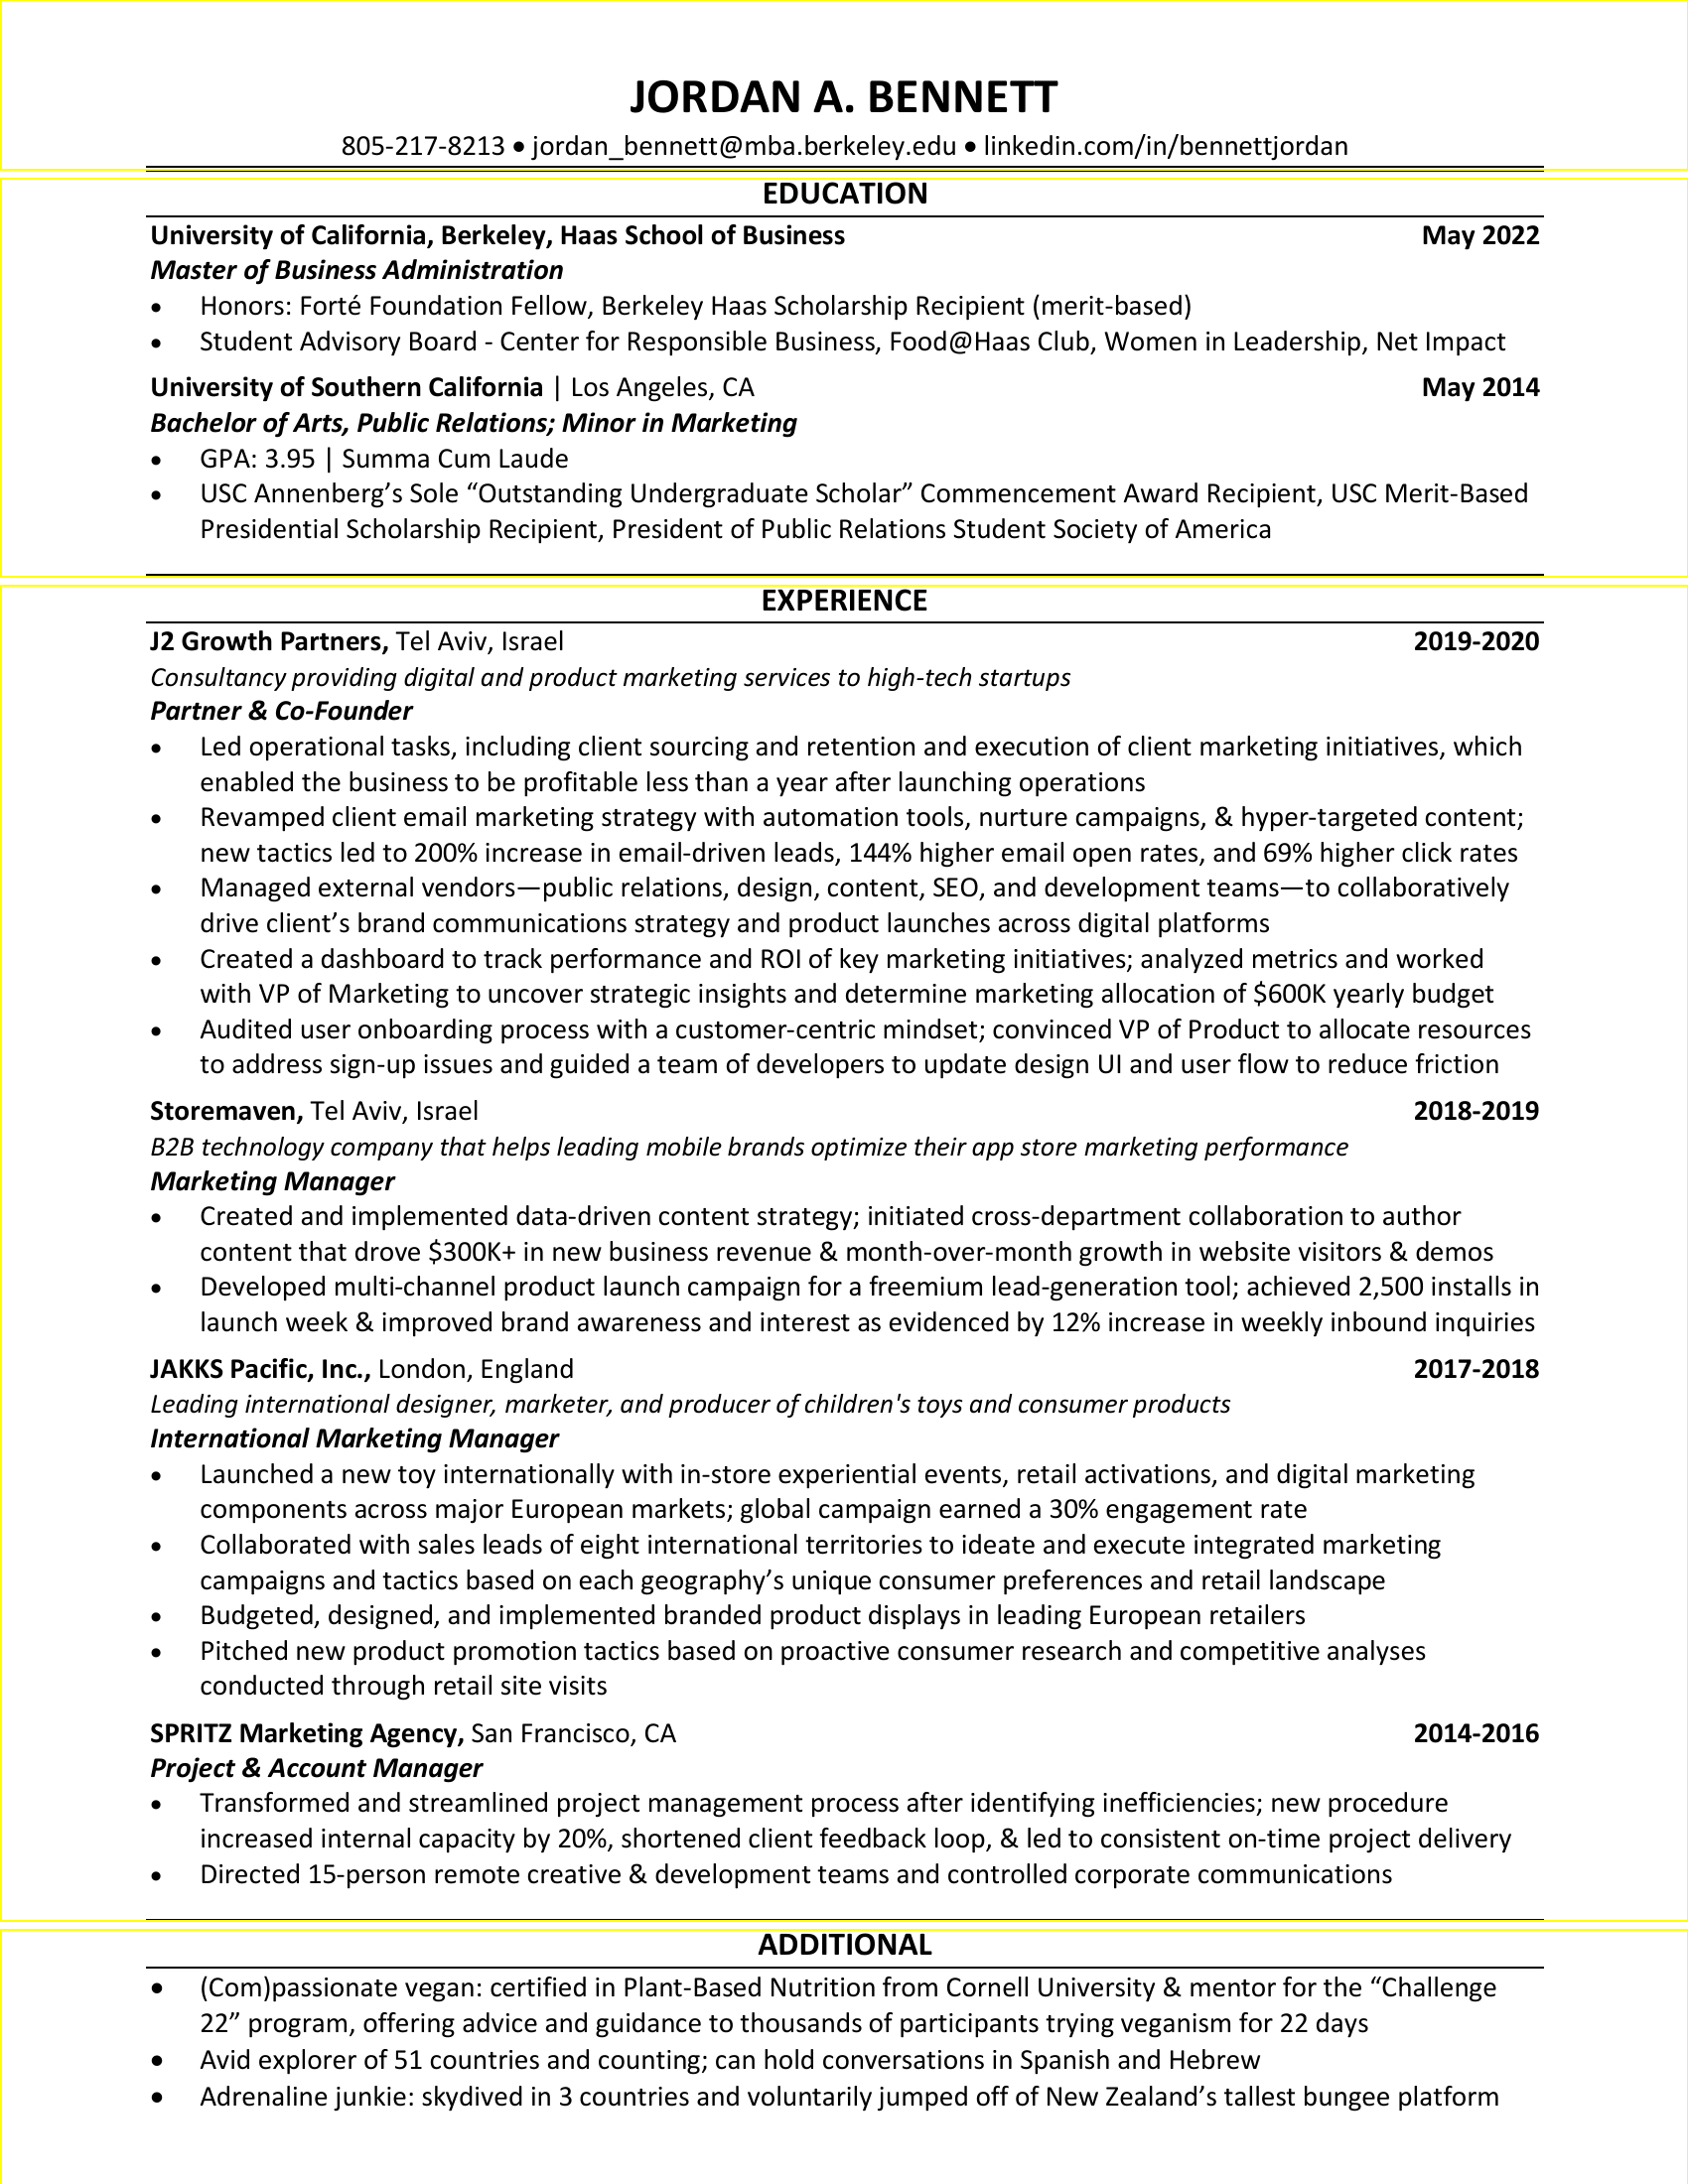

In [ ]:
draw_boxes(images[21],properNameBounds)

We saved the bounding box coordinates in the annotation XML file corresponding to the respective resume. Once we have collected the annotations, we can finally train the model.

##Modeling <a id="part-three"></a>

What modeling approach(es) are used for your problem? Is this classification or regression? Are you using a pre-trained model? What type of data was it originally
trained on? Demonstrate code used for hyperparameter optimization, for dealing with
imbalanced classes, and feature selection where applicable.

The modeling approach that we took to create the resume parsing model was to use MaskRCNN and EasyOCR to parse through the resumes and extract the information.

MaskRCNN is a pre-trained model generally used for object detection.
We trained this model on the resumes available to us and used it to classify different portions of a resume using bounding boxes for each section of the resume, the weights that we used prior to training came from COCO dataset and are pretrained with 80 different classes on about 330K images

MaskRCNN Link: https://github.com/matterport/Mask_RCNN

COCO Link: https://cocodataset.org/#home

Then for the text extraction part we used EasyOCR model which is an Optical Character Recognition model that is already trained on multiple languages (including english), has very high accuracy and it's very easy to use.

EasyOCR Link: https://github.com/JaidedAI/EasyOCR

Below you can see how the actual app is using our models, we defined this function `run_model(img_array)` that takes in an array with all the pictures you want to run the model on and runs it.

The function starts by loading the maskrcnn model and then for every picture it predicts the sections, then for every section in a picture it will extract the information using EasyOCR and save that information in a dataframe containing a row with the information from each image. The function returns a dataframe that has the parsed information out of every resume in the array passed as input

In [ ]:
def run_model(img_array):
    CLASS_NAMES = ['BG', 'Personal Info', 'Education', 'Skills', 'Projects', 'Work Experience', 'Extra']

    class SimpleConfig(mrcnn.config.Config):
        NAME = "coco_inference"

        GPU_COUNT = 1
        IMAGES_PER_GPU = 1

        NUM_CLASSES = len(CLASS_NAMES)

    model = mrcnn.model.MaskRCNN(mode="inference",
                                 config=SimpleConfig(),
                                 model_dir=os.getcwd())

    model.load_weights(filepath=r'D:\\ResumeIT\\RESUMEIT_Model_Finalized.h5',
                       by_name=True)

    class_dict = {'bg' : 0,
                  'Personal Info' : 1,
                  'Education' : 2,
                  'Skills' : 3,
                  'Projects' : 4,
                  'Work Experience' : 5,
                  'Extra' : 6
                }

    inv_class_dict = {0:'bg',
                  1:'Personal Info',
                  2:'Education',
                  3:'Skills',
                  4:'Projects',
                  5:'Work Experience',
                  6: 'Extra'
                }

    sections = ['Personal Info', 'Education', 'Skills', 'Projects', 'Work Experience', 'Extra']
    extracted_info_df = pd.DataFrame(columns=sections)

    #Assuming an array of images in cv2 format: img_array
    for image in img_array:

        pred = model.detect([image], verbose=0)
        pred = pred[0]
        #The bnd box outputed is [y1,x1,y2,x2]

        full_info = list()
        class_list = list()
        for i in range(len(pred['rois'])):
            img_pil = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            temp_img = PIL.Image.fromarray(img_pil)
            current_bnd_box = pred['rois'][i]
            current_box_class = pred['class_ids'][i]
            #pil_img.crop(box=[x1,y1,x2,y2])
            crop_box = [current_bnd_box[1], current_bnd_box[0], current_bnd_box[3], current_bnd_box[2]]
            crop_img = temp_img.crop(crop_box)

            #text for this section
            section_text = ""
            bounds = reader.readtext(np.array(crop_img),min_size=0,slope_ths=0.2,ycenter_ths=0.7,height_ths=0.6,width_ths=0.8)
            for b in bounds:
                section_text += " " + b[1]
            full_info.append([section_text])
            class_list.append(inv_class_dict[current_box_class])

        add_to_df = dict(zip(class_list,full_info))

        for key in sections:
            if key in add_to_df:
                continue
            else:
                add_to_df[key] = [""]

        temp_df = pd.DataFrame.from_dict(add_to_df)

        extracted_info_df = extracted_info_df.append(temp_df, ignore_index = True)

    return extracted_info_df

files = os.listdir(r'D:\\ResumeIT\\Testing\\Resumes_Smaller')
img_array = list()
for name in files:
    image = cv2.imread(r'D:\\ResumeIT\\Testing\\Resumes_Smaller\\' + name)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_array.append(image)

extracted_df = run_model(img_array)
extracted_df.head()

## Results <a id="part-four"></a>

Demonstrate your model’s performance. This should be in terms of quantitative
metrics, qualitative evaluation, visualizations and by walking through example inputs.
Briefly mention any areas where your model outperforms or underperforms.

Once the first version of the model was trained we were finally able to get a prediction out of it and it looked a lot like this:

In [ ]:
CLASS_NAMES = ['BG', 'Personal Info', 'Education', 'Skills', 'Projects', 'Work Experience', 'Extra']

class SimpleConfig(mrcnn.config.Config):
    NAME = "coco_inference"

    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    NUM_CLASSES = len(CLASS_NAMES)

model = mrcnn.model.MaskRCNN(mode="inference",
                             config=SimpleConfig(),
                             model_dir=os.getcwd())

model.load_weights(filepath='D:\\ResumeIT\\RESUMEIT_Model_Finalized.h5',
                   by_name=True)

image = cv2.imread("D:\\ResumeIT\\old_Resumes_11_30\\s112.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

pred = model.detect([image], verbose=0)

pred = pred[0]

mrcnn.visualize.display_instances(image=image,
                                  boxes=pred['rois'],
                                  masks=pred['masks'],
                                  class_ids=pred['class_ids'],
                                  class_names=CLASS_NAMES,
                                  scores=pred['scores'])

Where above you can see the predictions that our model made for that particular resume, and the bounding box has its class and confidence level on the top left corner

After a lot of research we concluded that the best evaluation metric for an object segmentation model would be mAP (Mean Average Precision). To get those metrics calculate the average precision for each class in your data based on your model predictions. Average precision is related to the area under the precision-recall curve for a class. Then we took the mean out of all those values so that we could find out the overall mAP of our model.

To calculate the AP we used a function already included in MRCNN package called compute_ap

`mrcnn.utils.compute_ap(np.array(boxes), class_id, masks, pred['rois'],pred['class_ids'], pred['scores'],pred['masks'],iou_threshold=0.75)`

The function takes in the ground truth boxes, ids and masks, as well as the predicted boxes, ids, masks and scores, and also a final parameter called `iou_threshold` which determines what's the threshold IoU (Intersect over Union) rate that categorizes a prediction as true or false. So we ran the metrics for three different IoUs to see how it affected the performance of the model, we ran on IoU = [0.75, 0.85, 0.95]


Before we can run the snippets for performance, lets just define this two functions that are going to make life a lot easier:

In [ ]:
#Section class =  1, "Personal Info")
#Section class =  2, "Education")
#Section class =  3, "Skills")
#Section class =  4, "Projects")
#Section class =  5, "Work Experience")
#Section class =  6, "Extra")

class_dict = {'bg' : 0,
              'Personal Info' : 1,
              'Education' : 2,
              'Skills' : 3,
              'Projects' : 4,
              'Work Experience' : 5,
              'Extra' : 6
             }

# A helper method to extract the bounding boxes from the annotation file
def extract_boxes(filename):
    class_dict = {'bg' : 0,
              'Personal Info' : 1,
              'Education' : 2,
              'Skills' : 3,
              'Projects' : 4,
              'Work Experience' : 5,
              'Extra' : 6
             }

    tree = xml.etree.ElementTree.parse(filename)

    root = tree.getroot()

    boxes = list()
    for obj in root.findall('./object'):
        name = obj.find('name').text
        xmin = int(obj.find('bndbox/xmin').text)
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymax = int(obj.find('bndbox/ymax').text)
        coors = [xmin, ymin, xmax, ymax]
        class_id = class_dict[name]
        box_array = [class_id,coors]
        print(box_array)
        boxes.append(box_array)


    width = int(root.find('.//size/width').text)
    height = int(root.find('.//size/height').text)
    return boxes, width, height

def load_mask(path_annotations):
    boxes, w, h = extract_boxes(path_annotations)
    masks = np.zeros([h, w, len(boxes)], dtype='uint8')

    class_ids = list()
    for i in range(len(boxes)):
        obj = boxes[i]
        box = obj[1]
        row_s, row_e = box[1], box[3]
        col_s, col_e = box[0], box[2]
        masks[row_s:row_e, col_s:col_e, i] = 1
        class_ids.append(obj[0])
    return masks, np.asarray(class_ids, dtype='int32')

For IoU = 75%

In [ ]:
print(os.listdir(r'D:\\ResumeIT\\Testing\\Resumes'))
files = os.listdir(r'D:\\ResumeIT\\Testing\\Resumes')

ap_results_75 = list()

for name in files:
    img_path = 'D:\\ResumeIT\\Testing\\Resumes\\' + name
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    pred = model.detect([image], verbose=0)
    pred = pred[0]

    xml_path = 'D:\\ResumeIT\\Testing\\Resume_Annotations\\' + name[:-4] +'.xml'
    b, h, w = extract_boxes(xml_path)
    boxes = list()
    for box in b:
        boxes.append(box[1])

    masks, class_id = load_mask(xml_path)

    ap_mult_res_try_75 = mrcnn.utils.compute_ap(np.array(boxes), class_id, masks, pred['rois'],pred['class_ids'], pred['scores'],pred['masks'],iou_threshold=0.75)
    ap_results_75.append(ap_mult_res_try_75)
print(ap_results_75[0])

For IoU = 85%

In [ ]:
print(os.listdir(r'D:\\ResumeIT\\Testing\\Resumes'))
files = os.listdir(r'D:\\ResumeIT\\Testing\\Resumes')

ap_results_85 = list()

for name in files:
    img_path = 'D:\\ResumeIT\\Testing\\Resumes\\' + name
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    pred = model.detect([image], verbose=0)
    pred = pred[0]

    xml_path = 'D:\\ResumeIT\\Testing\\Resume_Annotations\\' + name[:-4] +'.xml'
    b, h, w = extract_boxes(xml_path)
    boxes = list()
    for box in b:
        boxes.append(box[1])

    masks, class_id = load_mask(xml_path)

    ap_mult_res_try_85 = mrcnn.utils.compute_ap(np.array(boxes), class_id, masks, pred['rois'],pred['class_ids'], pred['scores'],pred['masks'],iou_threshold=0.85)
    ap_results_85.append(ap_mult_res_try_85)
print(len(ap_results_85))
print(ap_results_85[0])

For IoU = 95%

In [ ]:
print(os.listdir(r'D:\\ResumeIT\\Testing\\Resumes'))
files = os.listdir(r'D:\\ResumeIT\\Testing\\Resumes')

ap_results_95 = list()

for name in files:
    img_path = 'D:\\ResumeIT\\Testing\\Resumes\\' + name
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    pred = model.detect([image], verbose=0)
    pred = pred[0]

    xml_path = 'D:\\ResumeIT\\Testing\\Resume_Annotations\\' + name[:-4] +'.xml'
    b, h, w = extract_boxes(xml_path)
    boxes = list()
    for box in b:
        boxes.append(box[1])

    masks, class_id = load_mask(xml_path)

    ap_mult_res_try_95 = mrcnn.utils.compute_ap(np.array(boxes), class_id, masks, pred['rois'],pred['class_ids'], pred['scores'],pred['masks'],iou_threshold=0.95)
    ap_results_95.append(ap_mult_res_try_95)
print(len(ap_results_95))
print(ap_results_95[0])

And then finally a script to calculate the mAP for each of these IoU thresholds:

In [ ]:
map_75_values = list()
map_85_values = list()
map_95_values = list()
for i in range(len(ap_results_75)):
    map_75_values.append(ap_results_75[i][0])
    map_85_values.append(ap_results_85[i][0])
    map_95_values.append(ap_results_95[i][0])

map_75 = sum(map_75_values) / len(map_75_values)
map_85 = sum(map_85_values) / len(map_85_values)
map_95 = sum(map_95_values) / len(map_95_values)

print(map_75)
print(map_85)
print(map_95)

Before we demonstrate how we train the model, we need to address the underperforming parts of our model, the column based resumes where as you can see below our model is not very good at detecting:

In [ ]:
CLASS_NAMES = ['BG', 'Personal Info', 'Education', 'Skills', 'Projects', 'Work Experience', 'Extra']

class SimpleConfig(mrcnn.config.Config):
    NAME = "coco_inference"

    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    NUM_CLASSES = len(CLASS_NAMES)

model = mrcnn.model.MaskRCNN(mode="inference",
                             config=SimpleConfig(),
                             model_dir=os.getcwd())

model.load_weights(filepath='D:\\ResumeIT\\RESUMEIT_Model_Finalized.h5',
                   by_name=True)

image = cv2.imread(r'C:\\Users\\davba\\Downloads\\mem_resume_book-2_pages-to-jpg-0001.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

pred = model.detect([image], verbose=0)

pred = pred[0]

mrcnn.visualize.display_instances(image=image,
                                  boxes=pred['rois'],
                                  masks=pred['masks'],
                                  class_ids=pred['class_ids'],
                                  class_names=CLASS_NAMES,
                                  scores=pred['scores'])

Demonstrate how you train and save a final version of model for use by your actual product.

To actually train the model we used a couple of methods from MRCNN as well as wrote our own methods, so the first main thing we did was to expand the Dataset class that is defined in the MRCNN package so that we could load and work with our dataset, there are three methos being used:

1. load_dataset: This method will load the dataset and based on the `is_train` parameter will make it into a training or validation set

2. load_masks: This method creates the masks for each section based on the bounding box, it uses the `extract_boxes` method to get the desired values

3. extract_boxes: A method that takes in a xml file and extract the important information, the bounding boxes described in the xml file

```
#Using Keras==2.2.5 and tensorflow==1.13.1
class ResumeDataset(mrcnn.utils.Dataset):

    def load_dataset(self, dataset_dir, is_train=True):
        # Adding all possible sections
        self.add_class("dataset", 1, "Personal Info")
        self.add_class("dataset", 2, "Education")
        self.add_class("dataset", 3, "Skills")
        self.add_class("dataset", 4, "Projects")
        self.add_class("dataset", 5, "Work Experience")
        self.add_class("dataset", 6, "Extra")
        
        images_dir = dataset_dir + '\\Resumes\\'
        annotations_dir = dataset_dir + '\\Resume_Annotations\\'

        for filename in os.listdir(images_dir):
            # Image ID is file name without .jpg
            image_id = filename[:-4]
            #Lets leave resume s107 for validation
            if is_train and int(image_id[1:]) >= 85:
                continue

            if not is_train and int(image_id[1:]) < 85:
                continue


            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.xml'

            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        path = info['annotation']
        boxes, w, h = self.extract_boxes(path)
        masks = np.zeros([h, w, len(boxes)], dtype='uint8')

        class_ids = list()
        for i in range(len(boxes)):
            obj = boxes[i]
            box = obj[1]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index(obj[0]))
        return masks, np.asarray(class_ids, dtype='int32')

    # A helper method to extract the bounding boxes from the annotation file
    def extract_boxes(self, filename):
        tree = xml.etree.ElementTree.parse(filename)

        root = tree.getroot()

        boxes = list()
        for obj in root.findall('./object'):
        	name = obj.find('name').text
        	xmin = int(obj.find('bndbox/xmin').text)
        	ymin = int(obj.find('bndbox/ymin').text)
        	xmax = int(obj.find('bndbox/xmax').text)
        	ymax = int(obj.find('bndbox/ymax').text)
        	coors = [xmin, ymin, xmax, ymax]
        	box_array = [name,coors]
        	print(box_array)
        	boxes.append(box_array)    

            
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height

class ResumeConfig(mrcnn.config.Config):
    NAME = "resumes_cfg"

    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
    NUM_CLASSES = 7
    
    LEARNING_RATE = 0.001

    STEPS_PER_EPOCH =  131

```

Once that was defined we wrote a `train_model()` function to actually perform the training as you can see down below and then save the updated weights to the appropriate path and so we have the actual function defined and an example runnning it as well:

```
def train_model(model_path, num_epochs, final_model_path):

    # Training
    train_dataset = ResumeDataset()
    train_dataset.load_dataset(dataset_dir=r'D:\\ResumeIT', is_train=True)
    train_dataset.prepare()
    # Validation
    validation_dataset = ResumeDataset()
    validation_dataset.load_dataset(dataset_dir=r'D:\\ResumeIT', is_train=False)
    validation_dataset.prepare()
    
    #For Training;
    config = ResumeConfig()
    
    model = mrcnn.model.MaskRCNN(mode='training',
                                 model_dir='.log',
                                 config=config)
    model.keras_model.summary()
    
    #r'D:\\ResumeIT\\RESUMEIT_Model_20Epochs_262Steps.h5'
    model.load_weights(filepath=model_path, by_name=True)
    
    print("Weights loaded!")
    
    print("Training Started!")
    model.train(train_dataset=train_dataset,
                val_dataset=validation_dataset,
                learning_rate=config.LEARNING_RATE,
                epochs=num_epochs,
                layers='heads')
    
    model_path = r'D:\\ResumeIT\\RESUMEIT_Model_Finalized.h5'
    model.keras_model.save_weights(final_model_path)
    print("Model Saved!")

```


In [ ]:
from Train_MASKRCNN_Script import train_model

train_model("D:\\ResumeIT\\RESUMEIT_Model_Finalized.h5", 1, "D:\\ResumeIT\\testing.h5")

## Impact <a id="part-five"></a>

Working on this project was interesting to us because it gave us hands on experience with different machine learning models that we have discussed throughout our course. Additionally, it was very exciting working with Keystone to make a useful application that will help make their recruiting process more efficient.

Be it any combination of requirements Keystone is looking for in the ideal candidate, they can simply choose the features and have the tool give the desired results. What’s more is that this tool can be further modified to give the analysis of the potential candidates by letting our model learn from itself using certain machine learning tools. One example of this can be the tool giving us the percentage match of the ideal candidate with the requirements as well as the ranking of the resumes amongst the chosen. This tool can also be turned into a software with an OS independent performance. And hence it makes this tool diverse and flexible.

Two important impacts that needs to be addressed are coming from when the model is underperforming;

1. Missing Sections: When the model fails to detect a section then it won't include the information so the candidate might lose important information and have a negative impact in his/her recruitment

2. Overfitt towards Row-Based: As discussed before the data that was collected were mostly row based resumes, so the performance for column based resumes is really bad, which can lead to the information being categorized wrongfully or not at all and that can have a negative impact in his/her recruitment
